In [1]:
#(LOAD IMPORTS)
import TrainModels 
import ReplaysParser 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#(LOAD MODEL)
lstmWeightsPath = "../TrainedModels/lstm_all-features_batch1024-128_layers1024-512-256_30000.weights" # all features, 30k replays, 1024/512/256, 128 batch size
lstm = TrainModels.UseTrainedLSTMModel(lstmWeightsPath)
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 322)         0         
                                                                 
 lstm (LSTM)                 (None, None, 1024)        5517312   
                                                                 
 lstm_1 (LSTM)               (None, None, 512)         3147776   
                                                                 
 lstm_2 (LSTM)               (None, None, 256)         787456    
                                                                 
 dense (Dense)               (None, None, 2)           514       
                                                                 
Total params: 9,453,058
Trainable params: 9,453,058
Non-trainable params: 0
_________________________________________________________________
None


1/1 [==============================] - 0s 201ms/step


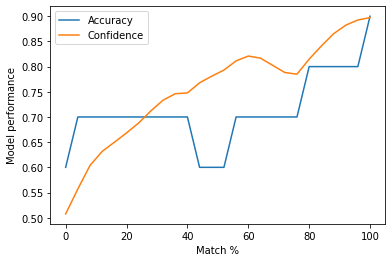

[0.6 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.7 0.7 0.7 0.7
 0.7 0.7 0.8 0.8 0.8 0.8 0.8 0.9]
[0.50750707 0.55707646 0.60369005 0.6316927  0.64982309 0.66835617
 0.6881762  0.71207559 0.73334052 0.74613688 0.74774989 0.76786128
 0.78096883 0.79319115 0.81137362 0.82094648 0.8168143  0.8025649
 0.78831038 0.78495538 0.81483583 0.8408603  0.86509031 0.88216032
 0.89257941 0.89732789]


In [5]:
#(EVALUATE MODEL)

validationDataFolder = "../SerializedReplaysForValidation"
hits = np.zeros(26)
confidences = np.zeros(26)
matches = np.zeros(26)

validationMatchesCount = 10
numberOfFeatures = 322 #142 for basic+army data


for j in range(validationMatchesCount):
    vectorizedReplayData = ReplaysParser.LoadVectorizedData(1,j, validationDataFolder)
    #vectorizedReplayData = ReplaysParser.ExtractBasicAndArmyData(vectorizedReplayData)

    matchLength = len(vectorizedReplayData[0])
    normalizedData, expectedResults =  TrainModels.PrepareInputData(vectorizedReplayData, 1, matchLength, numberOfFeatures)

    expectedOutput = expectedResults[0][0]
    predictions = lstm.predict(normalizedData)
    finalPredictions = predictions.argmax(axis=2)[0]
    
    for percent in range(26):
        i = round((percent/26)*matchLength)
        if(percent == 25):
            i = matchLength - 1

        percentPrediction = 0 if predictions[0][i][0] > predictions[0][i][1] else 1
        percentConfidence = max(predictions[0][i][0],predictions[0][i][1])

        matches[percent] = matches[percent] + 1
        confidences[percent] = confidences[percent] + percentConfidence
        if(percentPrediction == expectedOutput):
            hits[percent] = hits[percent] + 1

    print("Analyzed matches "+str(j)+"/"+str(validationMatchesCount),end='\r')

time = range(0,101,4)
plt.xlabel("Match %")
plt.ylabel("Model performance")
plt.plot(time, hits/validationMatchesCount, label="Accuracy")
plt.plot(time, confidences/validationMatchesCount, label="Confidence")
plt.legend()
plt.show()

print (hits/validationMatchesCount)
print (confidences/validationMatchesCount)

1/1 [==============================] - 0s 106ms/step


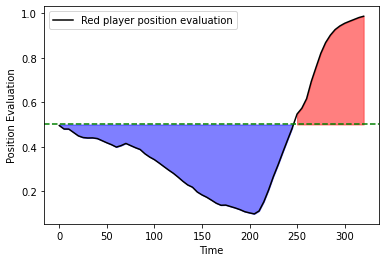

In [8]:
#(ANALYZE SINGLE REPLAY)

replayToEvaluatePath = "../SerializedReplaysForValidation/Curious Minds LE (3).SC2Replay_vectorized.jsonData"
numberOfFeatures = 322

vectorizedReplay = ReplaysParser.LoadVectorizedReplay(replayToEvaluatePath)
matchLength = len(vectorizedReplay)
normalizedData, _ =  TrainModels.PrepareInputData([vectorizedReplay], 1, matchLength, numberOfFeatures)

predictions = lstm.predict(normalizedData)
finalPredictions = predictions.argmax(axis=2)[0]

red = []
blue = []
time = []
conditionsRed = []
conditionsBlue = []
for tick in range(len(finalPredictions)):
    red.append(predictions[0][tick][0])
    blue.append(predictions[0][tick][1])
    time.append(tick*5)
    conditionsRed.append(red[-1]>0.5)
    conditionsBlue.append(red[-1]<0.5)


plt.xlabel("Time")
plt.ylabel("Position Evaluation")
plt.plot(time, red, label="Red player position evaluation" ,color='black')
plt.fill_between(time, red, 0.5, color='r', alpha=0.5, where=conditionsRed)
plt.fill_between(time, red, 0.5, color='b', alpha=0.5, where=conditionsBlue)
plt.axhline(y = 0.5, color = 'g', linestyle = '--')
plt.legend()
plt.show()
